In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Figure 6

#### Figure 6A

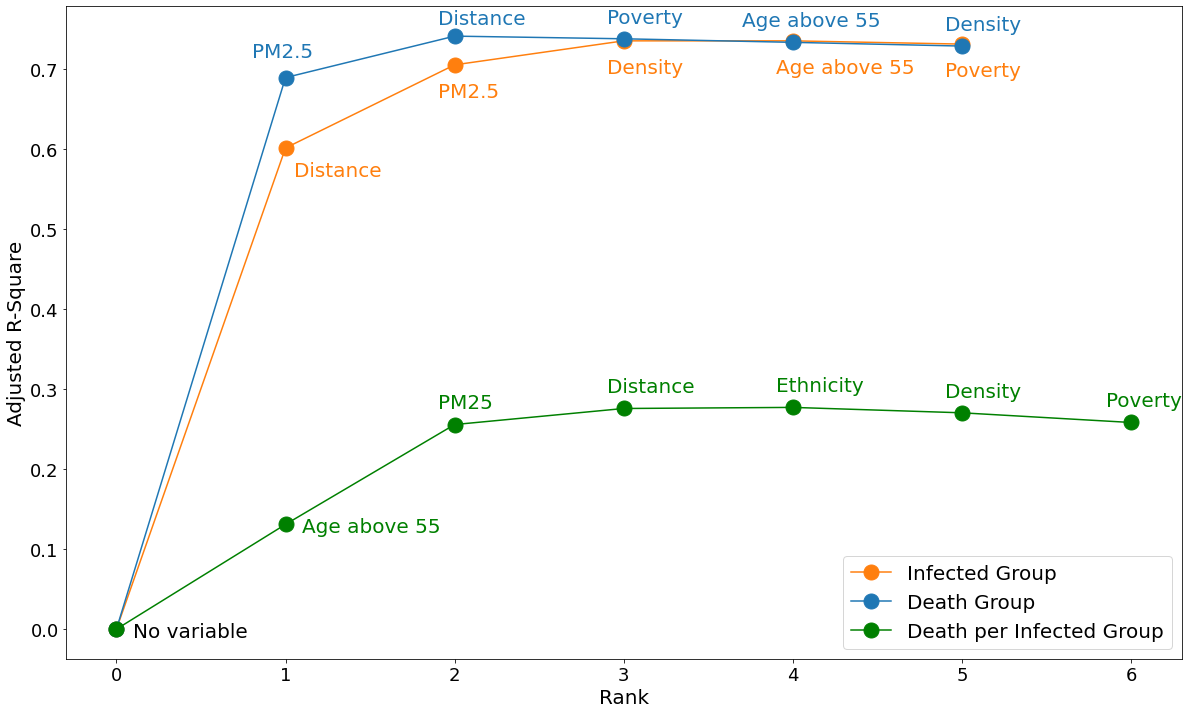

{'Pos10k': ['No variable', 'Distance', 'PM25', 'Density', 'AgeAB55', 'Poverty'], 'Deaths10k': ['No variable', 'PM25', 'Distance', 'Poverty', 'AgeAB55', 'Density'], 'DeathsPos': ['No variable', 'AgeAB55', 'PM25', 'Distance', 'HispAndAfrican', 'Density', 'Poverty']}
{'Pos10k': [0, 0.6012937587684195, 0.7051700487599155, 0.7351689691896153, 0.7351649122266126, 0.7311192054369138], 'Deaths10k': [0, 0.6892557125829368, 0.7410656404278783, 0.7377477468286613, 0.7333002773467053, 0.7286518240597971], 'DeathsPos': [0, 0.13094882780897976, 0.2556713636926602, 0.27574292915894005, 0.27711407024877677, 0.2703498423669002, 0.25825751164902466]}


In [ ]:
sydata = pd.read_csv("/covid19-project/final file/data/sycluster.csv")  

regdata = sydata[['County', 'Positives Case per 10K Population', 'Deaths per 10K Population', 'Deaths per 10K Positive Case']].copy()
regdata['County'] = regdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})

agedata = pd.read_csv("/covid19-project/final file/data/NY_55Plus.csv")
agedata['County'] = agedata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})

regdata = regdata.merge(agedata[['County', '%ab55']], on = 'County')

ethdata = pd.read_csv("/covid19-project/final file/data/NY_Counties_Census.csv") 
ethdata['County'] = ethdata['Area_Name'].map(lambda x: x[0:-7])  
ethdata['County'] = ethdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
ethdata['%His'] = ethdata['H_Population']/ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%AfA'] = ethdata['BA_population']/ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%ab65'] = ethdata['Total_age65plus'] / ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%HandA'] = ethdata['%His'] + ethdata['%AfA']

regdata = regdata.merge(ethdata[['County', '%HandA']], on = 'County')

poverdata = pd.read_csv("/covid19-project/final file/data/PovertyReport_percentage.csv") 
poverdata['county'] = poverdata['county'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
poverdata['County'] = poverdata['county']
poverdata = poverdata.loc[0:61]

regdata = regdata.merge(poverdata[['County', 'total_est_pct']], on = 'County')
regdata['total_est_pct'] = pd.to_numeric(regdata['total_est_pct'])

dendata = pd.read_csv("/covid19-project/final file/data/NY_Census.csv") 
dendata['Area_Name'] = dendata['Area_Name'].replace({'Staten Island County': 'Richmond County', 'New York County': 'Manhattan County', 'Kings County' : 'Brooklyn County'})
dendata = dendata[dendata['Area_Name'] != 'New York']
dendata['County'] = dendata['Area_Name'].map(lambda x: x[0:-7])
dendata['dens'] = dendata['Density.per.square.mile.of.land.area...Population']

regdata = regdata.merge(dendata[['County', 'dens']], on = 'County')

distance = pd.read_excel("/covid19-project/final file/data/Counties_NYC_Distance.xls")
distance['COUNTY'] = distance['COUNTY'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
distance['County'] = distance['COUNTY']

regdata = regdata.merge(distance[['County', 'Distance_Miles']], on = 'County')

pmdata = pd.read_csv("/covid19-project/final file/data/NY_Counties_PM2.5.csv")
pmdata['County'] = pmdata['County'].map(lambda x: x[:-7].title())
pmdata['County'] = pmdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
pmdata = pmdata.groupby('County').mean()
pmdata['County'] = pmdata.index
pmdata.index = pmdata.index.rename('')

regdata = regdata.merge(pmdata[['County', 'pm25']], on = 'County')

regdata = regdata.rename(columns={'Positives Case per 10K Population': 'Pos10k', 'Deaths per 10K Population': 'Deaths10k', \
                                  'Deaths per 10K Positive Case': 'DeathsPos', '%ab55': 'AgeAB55', '%HandA': 'HispAndAfrican', \
                                  'total_est_pct': 'Poverty', 'dens': 'Density', 'Distance_Miles': 'Distance', 'pm25': 'PM25' \
                                  })
regdata.to_csv('regression_data.csv')
regdata['const'] = 1

groups = ['Pos10k', 'Deaths10k', 'DeathsPos']
addedgroups = {}
accugroups = {}

for group in groups:
  if group != 'DeathsPos':
    paras = ['AgeAB55', 'Poverty', 'Density', 'Distance', 'PM25']
  else: 
    paras = ['AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25']

  added = ['const']
  accuracy = []

  while len(paras) != 0:
    willadd = ''
    inpop = 0
    radj = 0

    for i, para in enumerate(paras) :
      added.append(para)
      mod = sm.OLS(regdata[group], regdata[added])
      res = mod.fit()
      if res.rsquared_adj > radj :
        radj = res.rsquared_adj
        willadd = para
        inpop = i
      added.pop(-1)

    accuracy.append(radj)
    paras.pop(inpop)
    added.append(willadd)

  added.pop(0)
  
  added.insert(0, "No variable")
  accuracy.insert(0, 0)

  addedgroups[group] = added
  accugroups[group] = accuracy
  
plt.figure(figsize=(20,12))
xlist = [0,1,2,3,4,5]
accupos = accugroups['Pos10k']
plt.plot(xlist, accupos, marker='o', markersize=15, label = 'Infected Group', color = '#ff7f0e')
# ['HispAndAfrican', 'Poverty', 'Distance', 'Density', 'PM25', 'AgeAB55']
plt.text(1+0.05, accupos[1]-0.035, 'Distance', fontsize=20, color = '#ff7f0e')
plt.text(2-0.1, accupos[2]-0.04, 'PM2.5', fontsize=20, color = '#ff7f0e')
plt.text(3-0.1, accupos[3]-0.04, 'Density', fontsize=20, color = '#ff7f0e')
plt.text(4-0.1, accupos[4]-0.04, 'Age above 55', fontsize=20, color = '#ff7f0e')
plt.text(5-0.1, accupos[5]-0.04, 'Poverty', fontsize=20, color = '#ff7f0e')

accudeath = accugroups['Deaths10k']
plt.plot(xlist, accudeath, marker='o', markersize=15, label = 'Death Group', color = '#1f77b4')
# ['HispAndAfrican', 'Poverty', 'PM25', 'AgeAB55', 'Distance', 'Density']
plt.text(1-0.2, accudeath[1]+0.025, 'PM2.5', fontsize=20, color = '#1f77b4')
plt.text(2-0.1, accudeath[2]+0.015, 'Distance', fontsize=20, color = '#1f77b4')
plt.text(3-0.1, accudeath[3]+0.02, 'Poverty', fontsize=20, color = '#1f77b4')
plt.text(4-0.3, accudeath[4]+0.02, 'Age above 55', fontsize=20, color = '#1f77b4')
plt.text(5-0.1, accudeath[5]+0.02, 'Density', fontsize=20, color = '#1f77b4')

xlist = [0,1,2,3,4,5, 6]
accudeathpos = accugroups['DeathsPos']
plt.plot(xlist, accudeathpos, marker='o', markersize=15, label = 'Death per Infected Group', color = 'green')
# ['AgeAB55', 'PM25', 'Distance', 'HispAndAfrican', 'Density', 'Poverty']
plt.text(1+0.1, accudeathpos[1]-0.01, 'Age above 55', fontsize=20, color = 'green')
plt.text(2-0.1, accudeathpos[2]+0.02, 'PM25', fontsize=20, color = 'green')
plt.text(3-0.1, accudeathpos[3]+0.02, 'Distance', fontsize=20, color = 'green')
plt.text(4-0.1, accudeathpos[4]+0.02, 'Ethnicity', fontsize=20, color = 'green')
plt.text(5-0.1, accudeathpos[5]+0.02, 'Density', fontsize=20, color = 'green')
plt.text(6-0.15, accudeathpos[6]+0.02, 'Poverty', fontsize=20, color = 'green')

plt.text(0+0.1, accudeathpos[0]-0.01, 'No variable', fontsize=20, color = 'black')

plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Adjusted R-Square', fontsize = 20)
plt.xlabel('Rank', fontsize = 20)
plt.legend(fontsize = 20)
plt.savefig("simple_for.svg", format="svg")
plt.show()

print(addedgroups)
print(accugroups)

addedgroups['Pos10k'].append(None)
addedgroups['Deaths10k'].append(None)
g1 = pd.DataFrame(addedgroups)
g1['Rank'] = [*range(1,8,1)]


accugroups['Pos10k'].append(None)
accugroups['Deaths10k'].append(None)
g2 = pd.DataFrame(accugroups)
g2['Rank'] = [*range(1,8,1)]

accu = g1.merge(g2, on="Rank")
accu.rename(columns={'Pos10k_x':'Infection variables',	'Deaths10k_x':'Death variables', 	'DeathsPos_x':'Fatality variables',	'Pos10k_y':'Infection adj R-squared', 'Deaths10k_y':'Death adj R-squared', 	'DeathsPos_y':'Fatality adj R-squared'}, inplace=True)
accu = accu[['Rank', 'Infection variables', 'Infection adj R-squared', 'Death variables', 'Death adj R-squared', 'Fatality variables', 'Fatality adj R-squared']]
# accu.to_csv('FW_R-squared.csv', index=False)

#### Figure 6B

In [ ]:
sydata = pd.read_csv("/covid19-project/final file/data/sycluster.csv")  

regdata = sydata[['County', 'Positives Case per 10K Population', 'Deaths per 10K Population', 'Deaths per 10K Positive Case']].copy()
regdata['County'] = regdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})

agedata = pd.read_csv("/covid19-project/final file/data/NY_55Plus.csv")
agedata['County'] = agedata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})

regdata = regdata.merge(agedata[['County', '%ab55']], on = 'County')

ethdata = pd.read_csv("/covid19-project/final file/data/NY_Counties_Census.csv") 
ethdata['County'] = ethdata['Area_Name'].map(lambda x: x[0:-7])  
ethdata['County'] = ethdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
ethdata['%His'] = ethdata['H_Population']/ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%AfA'] = ethdata['BA_population']/ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%ab65'] = ethdata['Total_age65plus'] / ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%HandA'] = ethdata['%His'] + ethdata['%AfA']

regdata = regdata.merge(ethdata[['County', '%HandA']], on = 'County')

poverdata = pd.read_csv("/covid19-project/final file/data/PovertyReport_percentage.csv") 
poverdata['county'] = poverdata['county'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
poverdata['County'] = poverdata['county']
poverdata = poverdata.loc[0:61]

regdata = regdata.merge(poverdata[['County', 'total_est_pct']], on = 'County')
regdata['total_est_pct'] = pd.to_numeric(regdata['total_est_pct'])

dendata = pd.read_csv("/covid19-project/final file/data/NY_Census.csv") 
dendata['Area_Name'] = dendata['Area_Name'].replace({'Staten Island County': 'Richmond County', 'New York County': 'Manhattan County', 'Kings County' : 'Brooklyn County'})
dendata = dendata[dendata['Area_Name'] != 'New York']
dendata['County'] = dendata['Area_Name'].map(lambda x: x[0:-7])
dendata['dens'] = dendata['Density.per.square.mile.of.land.area...Population']

regdata = regdata.merge(dendata[['County', 'dens']], on = 'County')

distance = pd.read_excel("/covid19-project/final file/data/Counties_NYC_Distance.xls")
distance['COUNTY'] = distance['COUNTY'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
distance['County'] = distance['COUNTY']

regdata = regdata.merge(distance[['County', 'Distance_Miles']], on = 'County')

pmdata = pd.read_csv("/covid19-project/final file/data/NY_Counties_PM2.5.csv")
pmdata['County'] = pmdata['County'].map(lambda x: x[:-7].title())
pmdata['County'] = pmdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
pmdata = pmdata.groupby('County').mean()
pmdata['County'] = pmdata.index
pmdata.index = pmdata.index.rename('')

regdata = regdata.merge(pmdata[['County', 'pm25']], on = 'County')

regdata = regdata.rename(columns={'Positives Case per 10K Population': 'Pos10k', 'Deaths per 10K Population': 'Deaths10k', \
                                  'Deaths per 10K Positive Case': 'DeathsPos', '%ab55': 'AgeAB55', '%HandA': 'HispAndAfrican', \
                                  'total_est_pct': 'Poverty', 'dens': 'Density', 'Distance_Miles': 'Distance', 'pm25': 'PM25' \
                                  })

regdata['const'] = 1

regdata = regdata[regdata['County'] != 'Rockland']

print('Infection Group')
mod = sm.OLS(regdata['Pos10k'], regdata[['AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25', 'const']])
res = mod.fit()
print(res.summary())
print('\n\n')

print('Death Group')
mod = sm.OLS(regdata['Deaths10k'], regdata[['AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25', 'const']])
res = mod.fit()
print(res.summary())
print('\n\n')

print('Fatality Group')
mod = sm.OLS(regdata['DeathsPos'], regdata[['AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25', 'const']])
res = mod.fit()
print(res.summary())

Infection Group
                            OLS Regression Results                            
Dep. Variable:                 Pos10k   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     51.93
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           1.12e-20
Time:                        09:57:35   Log-Likelihood:                -302.27
No. Observations:                  61   AIC:                             618.5
Df Residuals:                      54   BIC:                             633.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
AgeAB55            0.0374   

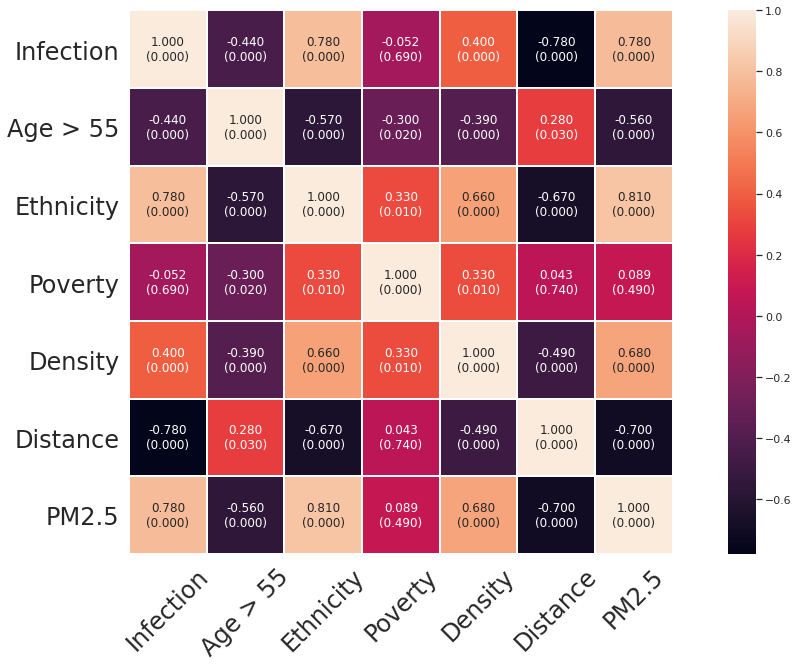

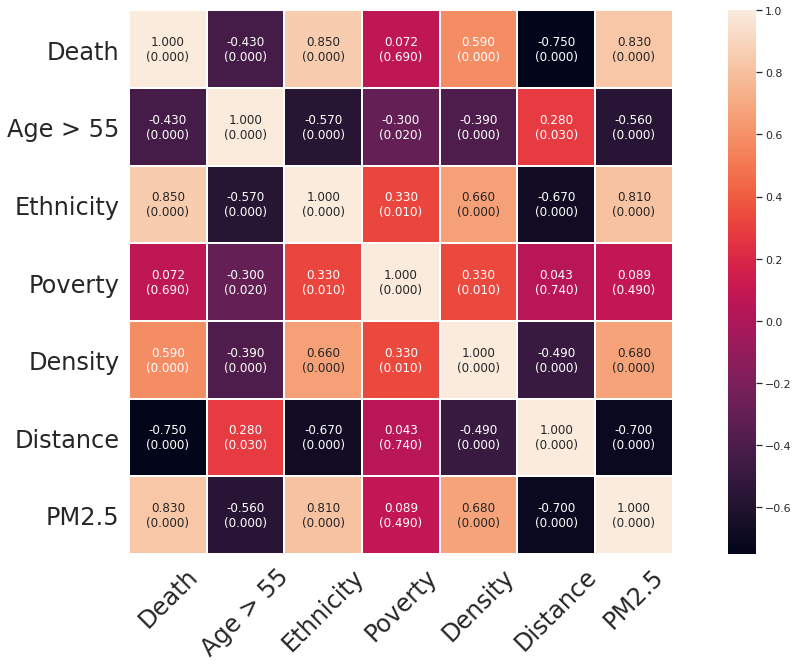

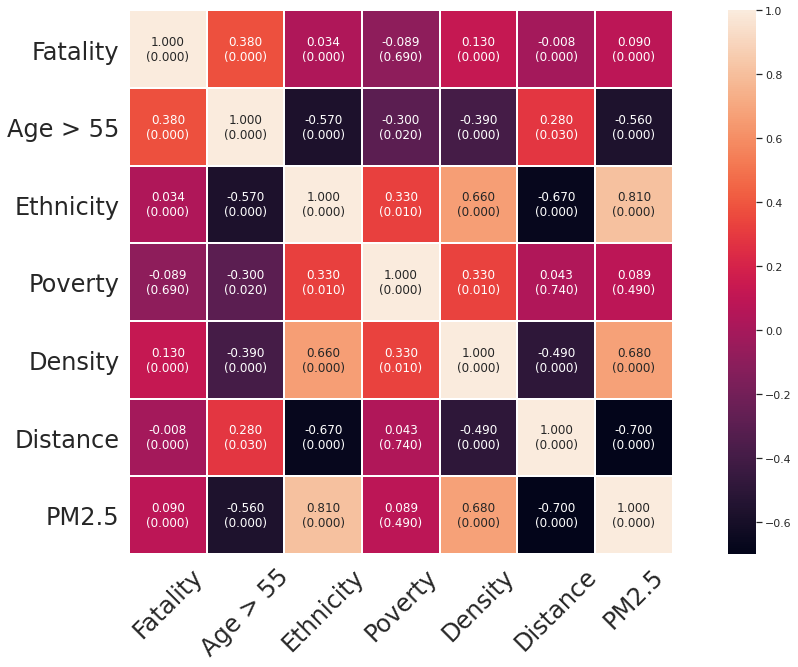

In [ ]:
sydata = pd.read_csv("/covid19-project/final file/data/sycluster.csv")

regdata = sydata[['County', 'Positives Case per 10K Population', 'Deaths per 10K Population', 'Deaths per 10K Positive Case', 'CaseCluster', 'DeathCluster', 'PosDeathCluster']].copy()
regdata['County'] = regdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})

agedata = pd.read_csv("/covid19-project/final file/data/NY_55Plus.csv")
agedata['County'] = agedata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})

regdata = regdata.merge(agedata[['County', '%ab55']], on = 'County')

ethdata = pd.read_csv("/covid19-project/final file/data/NY_Counties_Census.csv") 
ethdata['County'] = ethdata['Area_Name'].map(lambda x: x[0:-7])  
ethdata['County'] = ethdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
ethdata['%His'] = ethdata['H_Population']/ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%AfA'] = ethdata['BA_population']/ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%ab65'] = ethdata['Total_age65plus'] / ethdata['POP_ESTIMATE_2018'] * 100
ethdata['%HandA'] = ethdata['%His'] + ethdata['%AfA']

regdata = regdata.merge(ethdata[['County', '%HandA']], on = 'County')

poverdata = pd.read_csv("/covid19-project/final file/data/PovertyReport_percentage.csv") 
poverdata['county'] = poverdata['county'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
poverdata['County'] = poverdata['county']
poverdata = poverdata.loc[0:61]

regdata = regdata.merge(poverdata[['County', 'total_est_pct']], on = 'County')
regdata['total_est_pct'] = pd.to_numeric(regdata['total_est_pct'])

dendata = pd.read_csv("/covid19-project/final file/data/NY_Census.csv") 
dendata['Area_Name'] = dendata['Area_Name'].replace({'Staten Island County': 'Richmond County', 'New York County': 'Manhattan County', 'Kings County' : 'Brooklyn County'})
dendata = dendata[dendata['Area_Name'] != 'New York']
dendata['County'] = dendata['Area_Name'].map(lambda x: x[0:-7])
dendata['dens'] = dendata['Density.per.square.mile.of.land.area...Population']

regdata = regdata.merge(dendata[['County', 'dens']], on = 'County')

distance = pd.read_excel("/covid19-project/final file/data/Counties_NYC_Distance.xls")
distance['COUNTY'] = distance['COUNTY'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
distance['County'] = distance['COUNTY']

regdata = regdata.merge(distance[['County', 'Distance_Miles']], on = 'County')

pmdata = pd.read_csv("/covid19-project/final file/data/NY_Counties_PM2.5.csv")
pmdata['County'] = pmdata['County'].map(lambda x: x[:-7].title())
pmdata['County'] = pmdata['County'].replace({'Staten Island': 'Richmond', 'New York': 'Manhattan', 'Kings' : 'Brooklyn'})
pmdata = pmdata.groupby('County').mean()
pmdata['County'] = pmdata.index
pmdata.index = pmdata.index.rename('')

regdata = regdata.merge(pmdata[['County', 'pm25']], on = 'County')

regdata = regdata.rename(columns={'Positives Case per 10K Population': 'Pos10k', 'Deaths per 10K Population': 'Deaths10k', \
                                  'Deaths per 10K Positive Case': 'DeathsPos', '%ab55': 'AgeAB55', '%HandA': 'HispAndAfrican', \
                                  'total_est_pct': 'Poverty', 'dens': 'Density', 'Distance_Miles': 'Distance', 'pm25': 'PM25' \
                                  })

clusters = ['CaseCluster', 'DeathCluster', 'PosDeathCluster']
clustersName = ['Pos10k', 'Deaths10k', 'DeathsPos']
clustdict = {'CaseCluster' : 'Infection', 'DeathCluster': 'Death', 'PosDeathCluster': 'Fatality'}
i = 0
for cluster in clusters:
  corrdf = regdata[[clustersName[i], 'AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25']].corr()
  i += 1
  sns.set(rc={'figure.figsize':(20,10)})
  ax = sns.heatmap(corrdf, annot=True)

  df = regdata[['Pos10k', 'AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25']].copy()

  pval = [] 
  for ii in range(df.shape[1]): # rows are the number of rows in the matrix.
      for jj in range(df.shape[1]):
          try:
              y = df.columns[ii]
              x = df.columns[jj]
              cval = stats.pearsonr(df[x],df[y])
              pval.append(round(cval[1], 2))
          except ValueError:
              pval.iloc[ii,jj] = None
              
  ax = sns.heatmap(corrdf, annot=False, fmt = '.3f', square=1, linewidth=1, annot_kws={"fontsize":22}, ax = ax, cbar=False)

  n = 0
  for j in range(n, 49): 
    ax.texts[j].set_text(str(format(float(ax.texts[j].get_text()),'.3f')) + "\n(" + str(format(pval[n],'.3f')) + ")")
    n += 1
      
  ax.tick_params(axis='both', which='major', labelsize=24, labelbottom = True, bottom=False, top = False, labeltop=False)
  labels = [clustdict[cluster], 'Age > 55', 'Ethnicity', 'Poverty', 'Density', 'Distance', 'PM2.5']
  # ax.xticks(labels)
  ax.set_yticklabels(labels)
  ax.set_xticklabels(labels, rotation=45)
  plt.savefig("corr_"+clustdict[cluster]+".svg", format="svg")
  plt.show()

In [ ]:
regdata[[clustersName[2], 'AgeAB55', 'HispAndAfrican', 'Poverty', 'Density', 'Distance', 'PM25']].corr()

,DeathsPos,AgeAB55,HispAndAfrican,Poverty,Density,Distance,PM25
DeathsPos,1.000000,0.381045,0.033754,-0.089493,0.126866,-0.007764,0.089931
AgeAB55,0.381045,1.000000,-0.569862,-0.298937,-0.388875,0.283095,-0.561517
HispAndAfrican,0.033754,-0.569862,1.000000,0.326858,0.661455,-0.670926,0.814063
Poverty,-0.089493,-0.298937,0.326858,1.000000,0.334572,0.042860,0.088948
Density,0.126866,-0.388875,0.661455,0.334572,1.000000,-0.488895,0.677226
Distance,-0.007764,0.283095,-0.670926,0.042860,-0.488895,1.000000,-0.699401
PM25,0.089931,-0.561517,0.814063,0.088948,0.677226,-0.699401,1.000000
